# 0. Importing neccesary libraries

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem import WordNetLemmatizer as wnl
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score

import lightgbm as lgb
from sentence_transformers import SentenceTransformer

In [53]:
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('stopwords')

# 1. Data knowledge & preporation

In [60]:
data = pd.read_csv('toxic_comments.csv', sep=',')

data = data.drop(columns=[data.columns[0]])
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [62]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [64]:
pd.DataFrame(data.toxic.value_counts(normalize=True))

,proportion
toxic,
0,0.898388
1,0.101612


In [66]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [68]:
data.dtypes

text     object
toxic     int64
dtype: object

In [70]:
data['text_length'] = data.text.apply(len)
data.groupby(by='toxic').text_length.agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
toxic,,,,
0,403.956585,216.0,6,5000
1,302.932411,128.0,5,5000


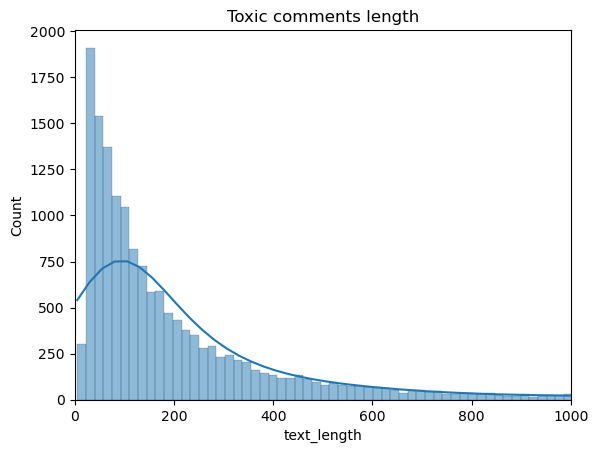

In [72]:
sns.histplot(x=data[data.toxic == 1].text_length, kde=True)
plt.xlim(0, 1000)
plt.title('Toxic comments length')
plt.show()

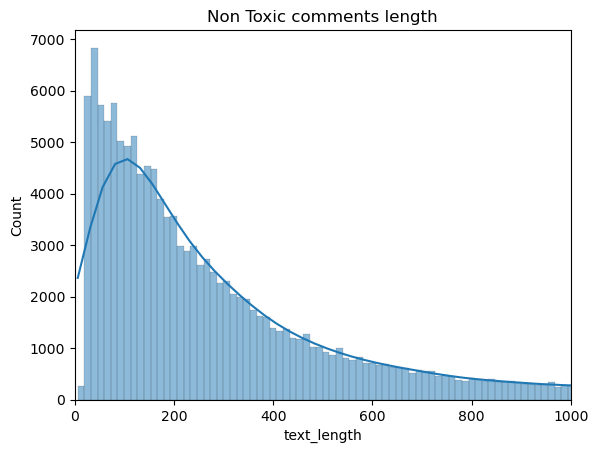

In [74]:
sns.histplot(x=data[data.toxic == 0].text_length, kde=True)
plt.title('Non Toxic comments length')
plt.xlim(0, 1000)
plt.show()

In [75]:
data[['toxic', 'text_length']].corr()

,toxic,text_length
toxic,1.000000,-0.051725
text_length,-0.051725,1.000000


In [78]:
data

,text,toxic,text_length
0,Explanation\nWhy the edits made under my usern...,0,264
1,D'aww! He matches this background colour I'm s...,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,622
4,"You, sir, are my hero. Any chance you remember...",0,67
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,295
159288,You should be ashamed of yourself \n\nThat is ...,0,99
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,81
159290,And it looks like it was actually you who put ...,0,116


# 2. Lemmatization & stop-words

In [107]:
def prep_text(text:str) -> str:
    prep_text = re.sub(r"[^a-z\s]", " ", text.lower())
    prep_text = prep_text.split()
    return prep_text

tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    new_text = []
    for word in prep_text(text):
        new_text.append(wnl().lemmatize(word, get_wordnet_pos(word)))
    return " ".join(new_text)

In [109]:
# it takes about 10 minutes to run this cell
# data['text'] = data['text'].apply(lemmatize_text)

In [111]:
# data.to_csv('lemmatized_text.csv', index=False)

In [113]:
data = pd.read_csv('lemmatized_text.csv').dropna()
data.isna().sum()

text           0
toxic          0
text_length    0
dtype: int64

## *1) most frequent toxic words*

In [115]:
toxic_corpus = data[data.toxic == 1].text
non_toxic_corpus = data[data.toxic == 0].text

vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
vectorizer.fit_transform(toxic_corpus)
toxic_words = vectorizer.get_feature_names_out()
toxic_words

array(['article', 'bitch', 'block', 'die', 'don', 'faggot', 'fuck', 'gay',
       'hate', 'just', 'know', 'like', 'make', 'nigger', 'page', 'people',
       'say', 'shit', 'suck', 'wikipedia'], dtype=object)

## *1) most frequent non-toxic words*

In [117]:
vectorizer.fit(non_toxic_corpus)
non_toxic_words = vectorizer.get_feature_names_out()
non_toxic_words

array(['add', 'article', 'don', 'edit', 'just', 'know', 'like', 'link',
       'make', 'need', 'page', 'people', 'say', 'source', 'talk', 'think',
       'time', 'use', 'user', 'wikipedia'], dtype=object)

# 3. Transforming data via TF-IDF

In [154]:
X = data['text']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('train', y_train.value_counts(normalize=True))
print('test', y_test.value_counts(normalize=True))

train toxic
0    0.897717
1    0.102283
Name: proportion, dtype: float64
test toxic
0    0.89801
1    0.10199
Name: proportion, dtype: float64


In [156]:
[i.shape for i in [X_test, X_valid, y_text, y_valid]]

[(31856,), (31857,), (31856,), (31857,)]

In [158]:
vectorizer = TfidfVectorizer(stop_words='english')

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_valid = vectorizer.transform(X_valid)

# 4. Fitting models on TF-IDF data:

## *1) logistic regression*

In [174]:
param_grid = {
    'C': [i for i in np.logspace(-1, 3, num=5)],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("best params for logistic regression", grid_search.best_params_)

model_1 = grid_search.best_estimator_
y_pred = model_1.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f'f1 score: {f1}')

best params for logistic regression {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
f1 score: 0.7705687945729692


## *2) Multinomial Naive Bayes*

In [177]:
param_grid = {
    "alpha": [i for i in np.logspace(-5, 2, num=8)],
}

model = MultinomialNB()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("best params for multinomial naive bayes", grid_search.best_params_)

model_2 = grid_search.best_estimator_
y_pred = model_2.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f'f1 score: {f1}')

best params for multinomial naive bayes {'alpha': 0.01}
f1 score: 0.6618732261116367


## *3) Gradient Boosting*

In [184]:
model_3 = lgb.LGBMClassifier(
    n_estimators=600,
    max_depth=100,
    learning_rate=0.07
)

evals_result = {}
model_3.fit(X_train,
          y_train,
          eval_set=[(X_test, y_test)],
          eval_metric = 'logloss',
         callbacks=[lgb.log_evaluation(20),
                    lgb.record_evaluation(evals_result)])

y_pred = model_3.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f'f1 score: {f1}')

[LightGBM] [Info] Number of positive: 9775, number of negative: 85793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.483122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417247
[LightGBM] [Info] Number of data points in the train set: 95568, number of used features: 8166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102283 -> initscore=-2.172109
[LightGBM] [Info] Start training from score -2.172109
[20]	valid_0's binary_logloss: 0.189614
[40]	valid_0's binary_logloss: 0.162321
[60]	valid_0's binary_logloss: 0.149157
[80]	valid_0's binary_logloss: 0.14134
[100]	valid_0's binary_logloss: 0.136038
[120]	valid_0's binary_logloss: 0.132216
[140]	valid_0's binary_logloss: 0.129426
[160]	valid_0's binary_logloss: 0.127208
[180]	valid_0's binary_logloss: 0.125501
[200]	valid_0's binary_logloss: 0.124101
[220]	valid_0's binary_logloss: 0.123085
[240]	valid_0's binary_logloss: 0.12237
[260]	valid_0's b

# 5. Getting data embedding using Sequence BERT

In [198]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [199]:
def prep_text_sbert(text:str) -> str:
    prep_text = re.sub(r"[^a-z\s]", " ", text.lower())
    prep_text = prep_text.split()
    return " ".join(prep_text)[:500]

In [202]:
data = pd.read_csv('toxic_comments.csv', sep=',').drop(columns=['Unnamed: 0'])
data['text'] = data.text.apply(prep_text_sbert)
comments = data["text"].tolist()

In [15]:
# it takes about an hour to run this code, results are in embedding_sbert.csv
# X_sbert = model.encode(comments, batch_size=64)
# X_sbert.shape

Batches:   0%|          | 0/2489 [00:00<?, ?it/s]

(159292, 384)

In [27]:
# new_data = pd.DataFrame(X_sbert)
# new_data['toxic'] = data['toxic']
# new_data.to_csv('embedding_sbert.csv', index=False) 

In [204]:
data = pd.read_csv('embedding_sbert.csv')
data.isna().sum().sum()

0

# 6. Fitting models on SBERT embedding data:

In [208]:
y = data.toxic
X  = data.drop(columns=['toxic'])

X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid_sbert, X_test_sbert, y_valid_sbert, y_test_sbert = train_test_split(X_test_sbert, y_test_sbert, test_size=0.5, random_state=42)

print('train', y_train_sbert.value_counts(normalize=True))
print('test', y_test_sbert.value_counts(normalize=True))

train toxic
0    0.897609
1    0.102391
Name: proportion, dtype: float64
test toxic
0    0.900217
1    0.099783
Name: proportion, dtype: float64


In [216]:
model_3_sbert = lgb.LGBMClassifier(
    n_estimators=290,
    max_depth=50,
    learning_rate=0.1,
)

evals_result = {}
model_3_sbert.fit(X_train_sbert,
          y_train_sbert,
          eval_set=[(X_test_sbert, y_test_sbert)],
          eval_metric = 'logloss',
          callbacks=[lgb.log_evaluation(10), lgb.record_evaluation(evals_result)])

y_pred = model_3_sbert.predict(X_valid_sbert)

f1 = f1_score(y_valid_sbert, y_pred)
print(f'f1-score: {f1}')

[LightGBM] [Info] Number of positive: 9786, number of negative: 85789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 95575, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102391 -> initscore=-2.170938
[LightGBM] [Info] Start training from score -2.170938
[10]	valid_0's binary_logloss: 0.228977
[20]	valid_0's binary_logloss: 0.198761
[30]	valid_0's binary_logloss: 0.183432
[40]	valid_0's binary_logloss: 0.173677
[50]	valid_0's binary_logloss: 0.16736
[60]	valid_0's binary_logloss: 0.162901
[70]	valid_0's binary_logloss: 0.159409
[80]	valid_0's binary_logloss: 0.156976
[90]	valid_0's binary_logloss: 0.155116
[100]	valid_0's binary_logloss: 0.153545
[110]	valid_0's binary_logloss: 0.152289
[120]	valid_0's binary_logloss: 0.151036
[130]	valid_0's binary_

In [218]:
param_grid = {
    'C': [i for i in np.logspace(-1, 3, num=5)],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train_sbert, y_train_sbert)

print("best params for logistic regression", grid_search.best_params_)

model_1_sbert = grid_search.best_estimator_
y_pred = model_1_sbert.predict(X_test_sbert)
f1 = f1_score(y_test_sbert, y_pred)

print(f'f1 score: {f1}')

best params for logistic regression {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
f1 score: 0.7215949188426253


In [224]:
param_grid = {
    'var_smoothing': [i for i in np.logspace(-5, 2, num=10)],
}

model = GaussianNB()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train_sbert, y_train_sbert)

print('best params for naive bayes', grid_search.best_params_)

model_2_sbert = grid_search.best_estimator_
y_pred = model_2_sbert.predict(X_test_sbert)
f1 = f1_score(y_test_sbert, y_pred)

print(f'f1 score: {f1}')

best params for naive bayes {'var_smoothing': 1e-05}
f1 score: 0.5637194782026982


# 7. Validation

In [233]:
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, y_proba)
    else:
        roc_auc = None
    metrics = {
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision": precision_score(y_valid, y_pred, zero_division=0),
        "Recall": recall_score(y_valid, y_pred, zero_division=0),
        "F1-score": f1_score(y_valid, y_pred, zero_division=0),
        "ROC-AUC": roc_auc
    }
    return metrics

In [293]:
validation = []

for i in [model_1_sbert,model_2_sbert,model_3_sbert]:
    validation.append(pd.DataFrame.from_dict(
        evaluate_model(i, X_valid_sbert, y_valid_sbert),
        orient='index'))

for i in [model_1, model_2, model_3]:
    validation.append(pd.DataFrame.from_dict(
        evaluate_model(i, X_valid, y_valid),
        orient='index'))
    
validation_table = pd.concat(validation, axis=1).T
validation_table['model'] = ['SBERT + log_reg', 'SBERT + NB', 'SBERT + Grad Boosting', 'TF-IDF + log_reg', 'TF-IDF + NB', 'TF-IDF + Grad Boosting']
validation_table.set_index('model', inplace=True)
validation_table

,Accuracy,Precision,Recall,F1-score,ROC-AUC
model,,,,,
SBERT + log_reg,0.948176,0.805685,0.642347,0.714804,0.956187
SBERT + NB,0.873972,0.433300,0.800683,0.562302,0.924477
SBERT + Grad Boosting,0.944441,0.808068,0.590810,0.682568,0.950568
TF-IDF + log_reg,0.958000,0.873107,0.674786,0.761242,0.967146
TF-IDF + NB,0.944376,0.853435,0.530528,0.654311,0.929560
TF-IDF + Grad Boosting,0.959601,0.883702,0.682695,0.770302,0.964176
